In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction  import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns

%matplotlib inline


In [15]:
df=pd.read_csv("housing.csv")
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [16]:
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df=df.fillna(0)



In [17]:
df_train_full, df_test=train_test_split(df,test_size=0.2, random_state =1)
df_train, df_val=train_test_split(df_train_full,test_size=0.25, random_state =1)
len(df_train),len(df_val),len(df_test)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_val=np.log1p(df_val.median_house_value.values)
y_test=np.log1p(df_test.median_house_value.values)
y_train=np.log1p(df_train.median_house_value.values)

# y_train=df_train.median_house_value.values
# y_test=df_test.median_house_value.values
# y_val=df_val.median_house_value.values
df_train=df_train.drop(['median_house_value'],axis=1)
df_val=df_val.drop(['median_house_value'],axis=1)
df_test=df_test.drop(['median_house_value'],axis=1)



In [18]:
train_dicts=df_train.to_dict(orient='records')
val_dicts=df_val.to_dict(orient='records')
test_dicts=df_test.to_dict(orient='records')


In [19]:
dv=DictVectorizer(sparse=True)
X_train=dv.fit_transform(train_dicts)
X_val=dv.fit_transform(val_dicts)
X_test=dv.fit_transform(test_dicts)
X_val


<3138x10 sparse matrix of type '<class 'numpy.float64'>'
	with 28242 stored elements in Compressed Sparse Row format>

## Question 1

In [20]:
regressor=DecisionTreeRegressor(max_depth=1)
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_val)
y_pred



array([12.30066927, 12.30066927, 11.60680734, ..., 11.60680734,
       11.60680734, 11.60680734])

In [21]:
print(export_text(regressor, feature_names=dv.get_feature_names()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



#### The answer for Most important split feature(Q1) is ocean_proximity


In [22]:
importances=list(regressor.feature_importances_)
features=list(dv.get_feature_names())


df_imp_features=pd.DataFrame({'importances': importances, 'features': features})
df_imp_features.sort_values('importances', ascending=False)

,importances,features
5,1.0,ocean_proximity=<1H OCEAN
0,0.0,households
1,0.0,housing_median_age
2,0.0,latitude
3,0.0,longitude
4,0.0,median_income
6,0.0,ocean_proximity=INLAND
7,0.0,population
8,0.0,total_bedrooms
9,0.0,total_rooms


## Question 2 

In [23]:
rf=RandomForestRegressor(n_estimators=10,random_state=1)

In [24]:
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [25]:
y_pred=rf.predict(X_val)
y_pred

array([12.21720358, 12.11642888, 11.57222122, ..., 11.73604439,
       11.25269032, 11.65289907])

In [26]:
from sklearn import metrics
mse=metrics.mean_squared_error(y_val, y_pred)
rmse=np.sqrt(mse)
print(f"The RMSE for Q2 is {rmse}")

The RMSE for Q2 is 0.24495290030597153


##  Question 3

In [27]:
scores=[]
for i in range(10,210, 10):
    rf=RandomForestRegressor(n_estimators=i,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_val)
    mse=metrics.mean_squared_error(y_val, y_pred)
    rmse=np.sqrt(mse)
    scores.append((i,rmse))
columns=['estimators','rmse']
df_scores=pd.DataFrame(scores,columns=columns)
                            


In [28]:
df_scores['rmse']=df_scores['rmse'].round(3)


df_scores.sort_values('estimators',ascending=True)


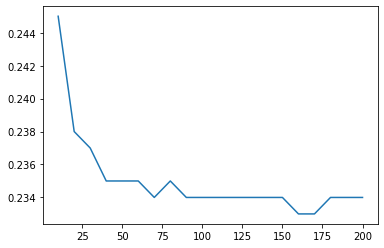

In [32]:
plt.plot(df_scores.estimators, df_scores.rmse.round(3))

#### The answer for Q3 is , after estimator 160 there is no improvement of RMSE.

## Q4 

In [33]:
scores=[]
for depth in[10, 15, 20, 25]:
    for i in range(10,210, 10):
        rf=RandomForestRegressor(n_estimators=i,random_state=1, max_depth=depth,n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred=rf.predict(X_val)
        mse=metrics.mean_squared_error(y_val, y_pred)
        rmse=np.sqrt(mse)
        scores.append((depth,i,rmse))
    columns=['max_depth','estimators','rmse']
    df_scores=pd.DataFrame(scores,columns=columns)

In [34]:
df_scores

,max_depth,estimators,rmse
0,10,10,0.250682
1,10,20,0.247455
2,10,30,0.246264
3,10,40,0.245029
4,10,50,0.245430
...,...,...,...
75,25,160,0.233395
76,25,170,0.233390
77,25,180,0.233572
78,25,190,0.233811


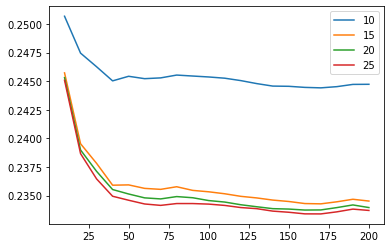

In [35]:
for depth in[10, 15, 20, 25]:
    df1 = df_scores[df_scores.max_depth == depth]
    plt.plot(df1.estimators, df1.rmse, label=depth)
plt.legend()
    

##### The answer for Q5 is max_depth of 25 gives least RMSE

## Q5

In [36]:
rf=RandomForestRegressor(n_estimators=10,random_state=1, max_depth=20,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_val)
       
   

In [37]:
importances=list(rf.feature_importances_)
features=list(dv.get_feature_names())


df_imp_features=pd.DataFrame({ 'features': features,'importances': importances})
df_imp_features.sort_values('importances', ascending=False).iloc[0:5]

,features,importances
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806


In [38]:
!pip install xgboost

##   Q6

In [39]:
import xgboost as xgb


In [40]:
features=dv.get_feature_names()
features=list(map(lambda x:x.replace('ocean_proximity=<1H OCEAN','ocean_proximity=1H OCEAN'),features))
dtrain=xgb.DMatrix(X_train,label=y_train,feature_names=features)
dval=xgb.DMatrix(X_val,label=y_val,feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [41]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model=xgb.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist)

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.31556	val-rmse:0.32382
[3]	train-rmse:0.28541	val-rmse:0.29965
[4]	train-rmse:0.26573	val-rmse:0.28417
[5]	train-rmse:0.25338	val-rmse:0.27463
[6]	train-rmse:0.24157	val-rmse:0.26770
[7]	train-rmse:0.23486	val-rmse:0.26423
[8]	train-rmse:0.22668	val-rmse:0.25820
[9]	train-rmse:0.21995	val-rmse:0.25444
[10]	train-rmse:0.21444	val-rmse:0.25179
[11]	train-rmse:0.21155	val-rmse:0.25054
[12]	train-rmse:0.20729	val-rmse:0.24791
[13]	train-rmse:0.20317	val-rmse:0.24628
[14]	train-rmse:0.20135	val-rmse:0.24630
[15]	train-rmse:0.19858	val-rmse:0.24522
[16]	train-rmse:0.19580	val-rmse:0.24445
[17]	train-rmse:0.19333	val-rmse:0.24395
[18]	train-rmse:0.19107	val-rmse:0.24284
[19]	train-rmse:0.18735	val-rmse:0.24127
[20]	train-rmse:0.18524	val-rmse:0.23978
[21]	train-rmse:0.18332	val-rmse:0.23963
[22]	train-rmse:0.18189	val-rmse:0.23892
[23]	train-rmse:0.18006	val-rmse:0.23847
[24]	train-rmse:0.17869	va

In [42]:
y_pred=model.predict(dval)

In [43]:
rmse = np.sqrt(MSE(y_val, y_pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.228623


In [44]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model=xgb.train(xgb_params,dtrain,num_boost_round=100,evals=watchlist)

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269
[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	va

In [45]:
y_pred=model.predict(dval)

In [46]:
rmse = np.sqrt(MSE(y_val, y_pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  0.232089
